In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset 
from torchvision import datasets, transforms 
import numpy as np


In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)


GPU State: cpu


In [3]:
# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

In [4]:
# Data importing for MNIST

trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transforms.ToTensor())
trainLoader = dset.DataLoader(trainSet, batch_size=64, shuffle=True)


In [12]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            #input is image 28*28
            nn.Conv2d(1, 4, kernel_size=5),
            nn.ReLU(),
            #input is image 4*(28-4)*(28-4)
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(),
            #input is image 8*(24-4)*(24-4)
            nn.Flatten(),
            nn.Linear(3200, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.LogSoftmax(dim=1)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3,16),
            nn.ReLU(),
            nn.Linear(16,3200),
            nn.ReLU(),
            nn.Unflatten(1,(8,20,20)),
            nn.ConvTranspose2d(8,4,kernel_size=5),
            nn.ReLU(),
            nn.ConvTranspose2d(4,1,kernel_size=5),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, input):
        encodedVal = self.encoder(input)
        decodedVal = self.decoder(encodedVal)
        return encodedVal, decodedVal


model = Net().to(device)
print(model)

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3200, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=3, bias=True)
    (8): LogSoftmax(dim=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3200, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(8, 20, 20))
    (5): ConvTranspose2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
    (9): Sigmoid()
  )
)


In [13]:
#defining parameters
epochs = 50
lr = 0.002
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)



In [20]:
#training the networks
embedded_vector = np.empty([0,3])
label_vector = np.empty([0])

for epoch in range(epochs,epochs+1):
    for data in trainLoader:
        inputs, labels = data[0].to(device),data[1].to(device)
        encoded, output = model(inputs)
        loss = criterion(output, inputs)
        loss.backward()
        optimizer.step()
        encoded = encoded.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        
        if epoch is epochs:
            embedded_vector = np.append(embedded_vector,encoded,axis=0)
            label_vector = np.append(label_vector,labels,axis=0)   
            

In [9]:
label_vector[10000:10500,]


array([], dtype=float64)

array([4., 6., 0., 5., 5., 1., 3., 1., 3., 8., 9., 1., 7., 6., 3., 3., 0.,
       8., 9., 1., 9., 3., 7., 8., 5., 7., 4., 9., 9., 7., 2., 3.])

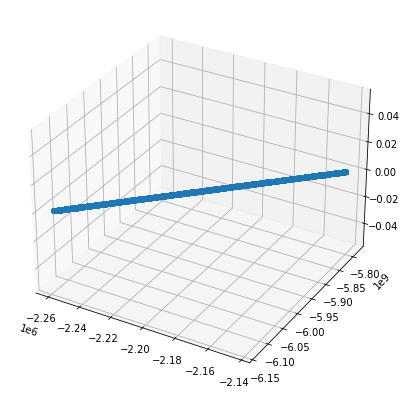

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(embedded_vector[:,0],embedded_vector[:,1],embedded_vector[:,2])
plt.show()

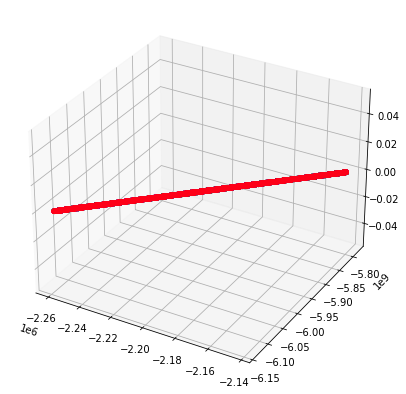

In [32]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
cmap = get_cmap(10)

for i in range(10):
    true_indices=[]
    index_binary = (label_vector==i)
    true_indices = [index for index, element in enumerate(index_binary) if element]
    ax.scatter3D(embedded_vector[true_indices,0],embedded_vector[true_indices,1],embedded_vector[true_indices,2], color=cmap(i))
    
plt.show()



    
    
    

In [31]:

for i in range(10):
    print(cmap(i))




(1.0, 0.0, 0.0, 1.0)
(1.0, 0.6562506562506562, 0.0, 1.0)
(0.6874986874986876, 1.0, 0.0, 1.0)
(0.031249343749343756, 1.0, 1.31250131249048e-06, 1.0)
(0.0, 1.0, 0.6249990812548694, 1.0)
(0.0, 0.718752625002625, 1.0, 1.0)
(0.0, 0.062501968751969, 1.0, 1.0)
(0.5937486874986869, 0.0, 1.0, 1.0)
(1.0, 0.0, 0.750000656250656, 1.0)
(1.0, 0.0, 0.09375, 1.0)


In [27]:
for i in range(10):
    index_binary = (label_vector==i)
    true_indices = [index for index, element in enumerate(index_binary) if element]
    print(true_indices[1])



21
29
5
20
22
28
9
8
14
19
